<a href="https://colab.research.google.com/github/jia020/myJupyterNotebooks/blob/master/NVCL_NMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NMM(National Mineral Map) For NVCL datasets.

NMM v2:
Added analyticalService together in Notbook.
Added countSum of mineral.
Added borehole Depth.
Added TSG file download link.
Added Batch spectrum download.


In [ ]:
pip install nvcl_kit

In [ ]:
pip install folium

In [2]:
#import all libs for olivine
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium.plugins import BeautifyIcon
from branca.element import Figure

pd.options.mode.chained_assignment = None
pd.set_option('display.width', 400)

In [3]:
#mount google drive
#from google.colab import drive
#drive.mount('/content/drive')
scalar ='Magnesite'#'Magnesite'#'Siderite'#'Olivine'#'Pyroxene'#Talc#Fayalite or Olivine-Fe
path=f'PathToData'
mineral=scalar
fo = open(f'{path}/{scalar}-cellout.txt', 'a')
def dual_print(f, *args, **kwargs):
  print(*args, **kwargs)
  print(*args, **kwargs, file=f)

In [4]:
import collections
from nvcl_kit.reader import NVCLReader
from nvcl_kit.param_builder import param_builder
import datetime

readersDict =collections.defaultdict(lambda: collections.defaultdict(dict))
statesList = ['nsw', 'tas', 'vic', 'qld', 'nt', 'sa', 'wa', 'csiro']
print(f'startTime:{datetime.datetime.now().time()}')
for state in statesList:
  param = param_builder(state, bbox = { "west": 110, "south": -46, "east": 155, "north": -6 })#bbox for whole Australia
  if not param:
    print(f"Cannot build parameters for {state}")
    break
  reader = NVCLReader(param)
  if not reader.wfs:
    print(f"No WFS for {state}")
    break
  readersDict[state] = reader
  dual_print(fo,f'{state}:{datetime.datetime.now().time()}')
  fo.flush()

startTime:12:45:39.302319
nsw:12:46:03.705284
tas:12:46:25.143760
vic:12:46:27.116179
qld:12:46:29.464528
nt:13:02:07.573690
sa:13:03:14.339009
wa:13:03:17.371064
csiro:13:03:18.587268


In [13]:
from io import StringIO

#get countSum for one borehole(nvcl_id)
def getMineralCountSum (myReader,nvcl_id,mineral,myState):
  #TIR Mineral
  algIDS=['68','102','118','126','134','62','56','142']
  #TIR group
  #algIDS=['69','103','119','127','135','63','57','143']
  dual_print(fo,f'start download spec for BH:{nvcl_id}')
  logs_data_list = myReader.get_logs_data(nvcl_id)
  scallist=[]
  for ld in logs_data_list:
    if ld.log_type == '1' and ld.algorithm_id in algIDS and ld.is_public=='true':
      scallist.append(ld.log_id)
  dual_print(fo,scallist)

  countSum = 0
  count = 0
  for logid in scallist:
    myInterval = 9999
    if 'qld' in myState:
      myInterval = 1
    bh_data0 = myReader.get_sampled_scalar_data(logid,interval=myInterval)
    buffer = StringIO(bh_data0.decode('utf-8'))
    df0 = pd.read_csv(filepath_or_buffer = buffer)
    df1=df0.loc[ df0.iloc[:,1].str.contains(mineral, na=False, case=False)]
    #dual_print(df1)
    if len(df1)==0:
      count = 0
    else:
      count = df1['Count'].sum()
    countSum += count
  return countSum
###############################
#buildup new {mineral}-xy-scalar.csv
#	scalar	State	BoreholeName	BoreholeURI	Latitude	Longitude	Value	Length
mineral = scalar#Pyroxene'#'Serpentine'#'Siderite'#'Magnesite' #'Talc'#Olivine
df = pd.read_csv(f'{path}/{mineral}-input.csv')
dual_print(fo,f'{datetime.datetime.now().time()}:Input: df size is {len(df)}')

dfW = pd.DataFrame(columns=['State',	'BoreholeName',	'BoreholeURI',	'x',	'y','countSum','Length','TsgLink'])

cc=0
scalarTest = 'fail'
fScalar = float(-1.0)

for row in df.itertuples():
  myState = row.State
  # if break somehow, you could continue on the index
  # if (row.Index < 1931):
  #   continue
  nvcl_id = row.BoreholeURI.rsplit('/', 1)[-1]

  fScalar = float(getMineralCountSum(readersDict[myState],nvcl_id,mineral,myState))
  #x is lng(-180-180) y is Lat(-90-90)
  dfW.loc[cc] = [row.State,row.BoreholeName,row.BoreholeURI,row.x,row.y,fScalar,row.Length,row.TsgLink]
  dual_print(fo,f'{datetime.datetime.now().time()}:{mineral}:{cc}:{fScalar}:{row.BoreholeURI}')
  fo.flush()
  cc+=1
#
dual_print(fo,f'cc:{cc}')
dfW.to_csv(f'{path}/{mineral}-xy-scalar.csv', index=False, sep=',', encoding='utf-8')
fo.close()


Input: df size is 1
start download spec for BH:MIN_003427
['b49764fe-687d-4be4-a117-aa80ce2508a', 'f29371d2-7696-47c4-abf6-af97dcd8904', '6da1f458-924a-4b80-b291-493b02bdb07']
Magnesite:0:13:32:57.497700:9699.0:https://gs.geoscience.nsw.gov.au/resource/feature/gsnsw/borehole/MIN_003427
cc:1


In [7]:
print(df)

                                                href           x          y             name state  Length                                            TsgLink
0  https://gs.geoscience.nsw.gov.au/resource/feat...  148.196749 -32.721937  Peak Hill: PHD2   nsw     282  https://nvclstore.z8.web.core.windows.net/NSW/...


In [ ]:
#show scalar on map
#get lightness according countSum
def scale_lightness(rgb, scale_l):
  import colorsys
  import matplotlib.colors as mc
  # convert rgb to hls
  h, l, s = colorsys.rgb_to_hls(*mc.to_rgb(rgb))
  # manipulate h, l, s values and return as rgb
  cT = colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)
  return mc.rgb2hex(cT, keep_alpha=False)
dfScalar=pd.read_csv(f'{path}/{mineral}-xy-scalar.csv')
#[['scalar', 'State',	'BoreholeName',	'BoreholeURI',	'Latitude',	'Longitude','Value','Length']]
cx = dfScalar['x'].mean()
cy = dfScalar['y'].mean()
countSumMax=dfScalar['countSum'].max()
countSumMean=dfScalar['countSum'].mean()
fig2=Figure(width=1024,height=768)
m2=folium.Map(location=[cy,cx],zoom_start=4)
fig2.add_child(m2)
# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',attr = 'Google',name = 'Google Maps',overlay = False,control = True),
    'Google Satellite': folium.TileLayer(tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',attr = 'Google',name = 'Google Satellite',overlay = False,control = True),
    'Google Terrain': folium.TileLayer(tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',attr = 'Google',name = 'Google Terrain',overlay = False,control = True),
    'Google Satellite Hybrid': folium.TileLayer(tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',attr = 'Google',name = 'Google Satellite',overlay = False,control = True),
    'Esri Satellite': folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr = 'Esri',name = 'Esri Satellite',overlay = False,control = True)
}
basemaps['Google Maps'].add_to(m2)
basemaps['Google Satellite Hybrid'].add_to(m2)
basemaps['Google Satellite'].add_to(m2)
basemaps['Google Terrain'].add_to(m2)
basemaps['Esri Satellite'].add_to(m2)
folium.LayerControl().add_to(m2)
#add circle-dot for scalar boreholes:
#blue is pass
#red is fail
#yellow is error
cc=0
countSumT = countSumMean#10000
print(f'countSumMax:{countSumMax}:countSumMean:{countSumMean}')
for row in dfScalar.itertuples():
  #if row.countSum > countSumT :
  folium.Marker(location=[row.y,row.x],popup=f'{row.BoreholeName}--countSum:{row.countSum}--Depth:{row.Length}m\n{row.BoreholeURI}\n{row.TsgLink}',icon=BeautifyIcon(icon_shape='circle-dot', border_color=scale_lightness('#0000FF',float(row.countSum/countSumMax)*1.7), border_width=5,)).add_to(m2)
  cc+=1  
m2.save(f'{path}/{mineral}-NMM-map.html')
m2

In [22]:
#Batch downloading scalar spec data as csv for boreholes nvcl_id
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"
from io import StringIO
import os
import array
fo = open(f'{path}/{mineral}-spec-cellout.txt', 'a')
def dual_print(f, *args, **kwargs):
  print(*args, **kwargs)
  print(*args, **kwargs, file=f)

#nvcl_id = '16794'#137872'#'PND0110'#'PDD446'#'PND0110'#'ADH 001'#'10350'
#nvcl_id = '104021'
# algIDS is not version, but could map to version
#VNIR group
#algIDS=['83','97','8','21','27']

#VNIR Mineral
#algIDS=['82','96','7','20','26']

#SWIR group
#algIDS=['75','89','109','41','33','2','13','49']

#SWIR Mineral
#algIDS=['74','88','108','40','32','1','12','48']

#TIR group
#algIDS=['69','103','119','127','135','63','57','143']

#TIR Mineral
algIDS=['68','102','118','126','134','62','56','142']
specNumLimit = 10
specGapMeters = 5
specNumLimitBH = 3
#build up top scalar countSum bhList for download Spectrum later.
dfScalar=pd.read_csv(f'{path}/{mineral}-xy-scalar.csv')
dfScalar2Download = dfScalar.sort_values(by=['countSum'], ascending=False)
countBH = 0
for row in dfScalar2Download.itertuples():
  nvcl_id = row.BoreholeURI.rsplit('/', 1)[-1]
  myState = row.State
  if ('wa' in myState):
    continue
  if (myState not in readersDict):
    dual_print(fo, f'{myState}not in readersDict')
    continue
  dual_print(fo, f'{myState}:{nvcl_id}:start download spec:')
  myReader = readersDict[myState]
  logs_data_list = myReader.get_logs_data(nvcl_id)
  scallist=[]
  for ld in logs_data_list:
    if ld.log_type == '1' and ld.algorithm_id in algIDS and ld.is_public=='true':
      scallist.append(ld.log_id)
  dual_print(fo, scallist)
  bh_data = myReader.get_scalar_data(scallist)
  buffer = StringIO(bh_data.decode('utf-8'))
  df = pd.read_csv(filepath_or_buffer = buffer)
  mineral = scalar #'Magnesite'
  dfS=df.loc[ (df.iloc[:,2].str.contains(mineral, na=False, case=False)) | (df.iloc[:,3].str.contains(mineral, na=False, case=False)) | (df.iloc[:,4].str.contains(mineral, na=False, case=False)) ]
  if len(dfS) < 2:
    dual_print(fo, dfS)
    dual_print(fo, f'BAD:no scalar[ {mineral}] in database')
    ####################################################################
  else:
    speclogs = myReader.get_spectrallog_data(nvcl_id)
    dfSS = dfS
    cc = 0
    previousDepth = 0
    for index, row in dfS.iterrows():
      if (row.StartDepth - previousDepth) < specGapMeters:
        continue # 1 spec per specGapMeters
      previousDepth = row.StartDepth
      cc += 1
      if cc > specNumLimit: # max spec from a BH
        dual_print(fo, f'outOfLimit:{cc}')
        break
      for speclog in speclogs:
        if speclog.sample_count > 0:
          wvName=f'WV-{speclog.wavelengths[0]}-{speclog.wavelengths[1]-speclog.wavelengths[0]}-{speclog.wavelengths[-1]}'.replace('.','_')
          if wvName not in dfSS.columns:
            dfSS[wvName] = ''
          spec_data=myReader.get_spectrallog_datasets(speclog.log_id,start_sample_no=index,end_sample_no=index)
          U = array.array("f")
          U.frombytes(spec_data)
          spec_dataS=",".join(map(str, U))
          dfSS.loc[index,wvName] = spec_dataS

    #save the raw spectrum into file
          
    dfSS.to_csv(f'{path}/{mineral}-spec-{myState}-{nvcl_id}.csv', index=False, sep=',', encoding='utf-8')
    dual_print(fo, f'{path}/{mineral}-spec-{myState}-{nvcl_id}.csv')
    dual_print(fo, f'{datetime.datetime.now().time()}:{myState}:{nvcl_id}:specNumLimit:{specNumLimit}:specGapMeters:{specGapMeters}:total specs:{len(dfSS)}')
    fo.flush()
#########for BH
  if countBH >= specNumLimitBH: #we only download  spec for limited boreholes(specNumLimitBH)
    break
  countBH+=1  
fo.close()  

nsw:MIN_003427:start download spec:
['f29371d2-7696-47c4-abf6-af97dcd8904', 'b49764fe-687d-4be4-a117-aa80ce2508a', '6da1f458-924a-4b80-b291-493b02bdb07']
outOfLimit:11
nsw:MIN_003427:13:46:38.627879:specNumLimit:10:specGapMeters:5:total specs:9699


      StartDepth  EndDepth   Min2_ujCLST   Min1_ujCLST      Min3_ujCLST                                WV-380_0-4_0-2500_0                             WV-6000_0-25_0-14500_0
8        5.33690   5.33690        Quartz  Pyrophyllite        Magnesite  0.15308400988578796,0.15018144249916077,0.1464...  0.05956403166055679,0.059205181896686554,0.058...
153     10.36048  10.36048        Quartz  Pyrophyllite        Magnesite  0.38219699263572693,0.3751508891582489,0.36688...  0.06794202327728271,0.0656815692782402,0.06250...
357     15.37917  15.37917  Pyrophyllite        Quartz        Magnesite  0.3117395341396332,0.3073684573173523,0.301876...  0.10216766595840454,0.10099616646766663,0.0978...
480     20.79354  20.79354        Quartz  Pyrophyllite        Magnesite  0.28826677799224854,0.2839204668998718,0.27865...  0.06521657109260559,0.063118577003479,0.060621...
769     25.79665  25.79665     Muscovite     Magnesite  Montmorillonite  0.49456551671028137,0.49013471603393555,0.4844...  0.0776

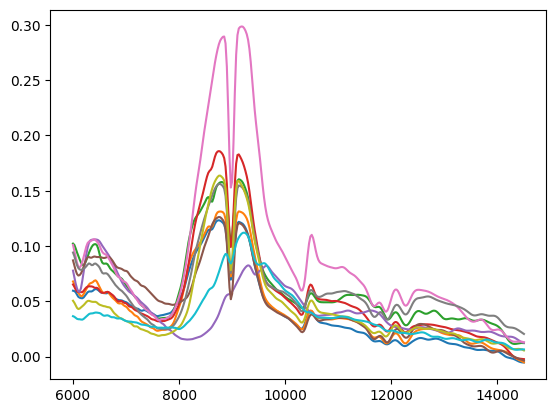

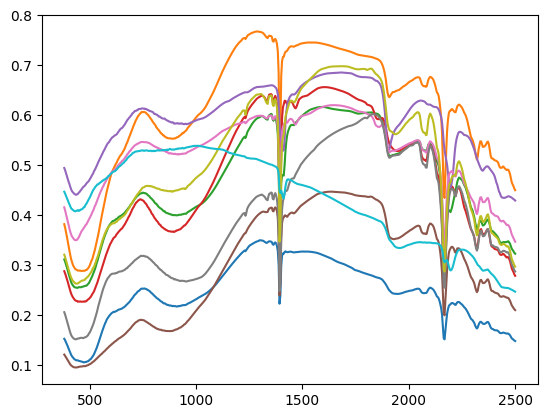

In [23]:
#Plot the spectrum chart for one borehole(etc:Magnesite-spec-sa-1575.csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"
#load spectrum from file
dfSS = pd.read_csv(f'{path}/{mineral}-spec-nsw-MIN_003427.csv') #Magnesite-spec-nsw-MIN_003427
dfSS.replace('', np.nan, inplace=True)
dfSS.dropna(inplace = True)
print(dfSS)
#buildup wvLengths array from column name
wv1 = dfSS.columns[-1]
wv11 = wv1.split('-')
wv1Start = float(wv11[1].replace('_','.'))
wv1Step= float(wv11[2].replace('_','.'))
wv1End = float(wv11[3].replace('_','.'))
wv1Lengths = np.arange(wv1Start, wv1End+wv1Step,wv1Step,dtype=float)

wv2 = dfSS.columns[-2]
wv22 = wv2.split('-')
wv2Start = float(wv22[1].replace('_','.'))
wv2Step= float(wv22[2].replace('_','.'))
wv2End = float(wv22[3].replace('_','.'))
wv2Lengths = np.arange(wv2Start, wv2End+wv2Step,wv2Step,dtype=float)
#init a empty dataframe
cnames=['wvLengths']
df1 = pd.DataFrame(columns=cnames)
df1['wvLengths'] = wv1Lengths
df2= pd.DataFrame(columns=cnames)
df2['wvLengths'] = wv2Lengths
#fillup the spec column into dataframe
#indexList = [611,987]
for index, row in dfSS.iterrows():
  # if index !=indexList: #611: #If I want a specific row
  #   continue
  specName = f'spec{index}'
  spec1 = np.array(row[wv1].split(','),dtype=np.float32)
  spec2 = np.array(row[wv2].split(','),dtype=np.float32)
  df1[specName] = spec1
  df2[specName] = spec2

#plot all specs
fig,ax = plt.subplots()
for col in df1.columns:
  if col == 'wvLengths':
    continue
  ax.plot(df1['wvLengths'],df1[col],label=col)
plt.savefig(f'{path}/{mineral}-spec-{nvcl_id}-TIR.png')

fig1,ax1 = plt.subplots()
for col in df2.columns:
  if col == 'wvLengths':
    continue
  ax1.plot(df2['wvLengths'],df2[col],label=col)

plt.savefig(f'{path}/{mineral}-spec-{nvcl_id}-SWIR.png')



In [ ]:
#Single Download scalar spec data as csv for borehole nvcl_id
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"
import io
import array
nvcl_id = '443'#'ADH 001'#'10350'

#pass,tas,ML048,http://www.mrt.tas.gov.au/resource/feature/mrt/borehole/10350,-41.69823623,145.32070134
#pass,tas,Forest-1,http://www.mrt.tas.gov.au/resource/feature/mrt/borehole/6200,-40.8151763,145.25523887


###############
# algIDS is not version, but could map to version
#VNIR group
#algIDS=['83','97','8','21','27']

#VNIR Mineral
#algIDS=['82','96','7','20','26']

#SWIR group
#algIDS=['75','89','109','41','33','2','13','49']

#SWIR Mineral
#algIDS=['74','88','108','40','32','1','12','48']

#TIR group
#algIDS=['69','103','119','127','135','63','57','143']

#TIR Mineral
algIDS=['68','102','118','126','134','62','56','142']
################

# Log name has 2 parts:
# 1. Min1,2,3 = 1st, 2nd, 3rd most common mineral
#    OR Grp1,2,3 = 1st, 2nd, 3rd most common group of minerals
# 2. uTSAV = visible light, uTSAS = shortwave IR, uTSAT = thermal IR
#
# These combine to give us a class name such as 'Grp1 uTSAS'
#
# Here we extract data for log type '1' and log name 'Grp1 uTSAS'
print(f'start download spec for BH:{nvcl_id}')
logs_data_list = reader.get_logs_data(nvcl_id)
scallist=[]
for ld in logs_data_list:
  if ld.log_type == '1' and ld.algorithm_id in algIDS and ld.is_public=='true':
    scallist.append(ld.log_id)

bh_data = reader.get_scalar_data(scallist)
print(f'bh_data:{len(bh_data)}')
buffer = io.StringIO(bh_data.decode('utf-8'))
df = pd.read_csv(filepath_or_buffer = buffer)
dfS=df.loc[ (df.iloc[:,2].str.contains(scalar, na=False, case=False)) | (df.iloc[:,3].str.contains(scalar, na=False, case=False)) | (df.iloc[:,4].str.contains(scalar, na=False, case=False)) ]
#dfS=df.loc[ (df.iloc[:,2] == scalar) | (df.iloc[:,3] == scalar) | (df.iloc[:,4] == scalar) ]
if len(dfS) < 2:
  print(dfS)
  print('BAD:no scalar in database')
else:
  ####################################################################
  speclogs = reader.get_spectrallog_data(nvcl_id)
  dfSS = dfS
  for index, row in dfS.iterrows():
    for speclog in speclogs:
      if speclog.sample_count > 0:
        wvName=f'WV-{speclog.wavelengths[0]}-{speclog.wavelengths[1]-speclog.wavelengths[0]}-{speclog.wavelengths[-1]}'.replace('.','_')
        if wvName not in dfSS.columns:
          dfSS[wvName] = ''
        spec_data=reader.get_spectrallog_datasets(speclog.log_id,start_sample_no=index,end_sample_no=index)
        U = array.array("f")
        U.frombytes(spec_data)
        spec_dataS=",".join(map(str, U))
        dfSS.loc[index,wvName] = spec_dataS
  #save the raw spectrum into file
  dfSS.to_csv(f'{path}/{mineral}-spec-{myState}-{nvcl_id}.csv', index=False, sep=',', encoding='utf-8')
  print(f'total specs:{len(dfSS)}')
  print(dfSS.head(5))
